# Task 1

# Ridge regression 

### Initialization

In [1]:
%matplotlib inline
import numpy as np
import math
import h5py
import random
import pyJHTDB
import time as tt
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters
import skimage.morphology as morphology
from skimage.morphology import square
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib import cm
import scipy.io as sio
import time
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Ridge,RidgeCV,RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold # import KFold
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family':"Times New Roman"}
pylab.rcParams.update(params)
# load shared library
lTDB = pyJHTDB.libJHTDB()
#initialize webservices
lTDB.initialize()

#Add token
auth_token  = "edu.jhu.burgers-2e898d7f"
lTDB.add_token(auth_token)

dataset = 'transition_bl'

spatialInterp  = 0  # no spatial interpolation
temporalInterp = 0  # no time interpolation
FD4NoInt       = 40 # 4th-order FD, no spatial interpolation

### Get training and test data from HDF5 files

In [2]:
#Read Training and Test data
data_t0 = h5py.File('data_t0_TNT_45x30x48.h5','r')
data_t1000 = h5py.File('data_t1000_TNT_45x30x48.h5','r')
Z=data_t0['Z']
X=data_t0['X']
Y=data_t0['Y']
x=X[1,:,1]
y=Y[:,1,1]
z=Z[1,1,:]

### Display data label

In [3]:
list(data_t0.keys())

['TNT',
 'X',
 'Y',
 'Z',
 'dudx',
 'dudy',
 'dudz',
 'dvdx',
 'dvdy',
 'dvdz',
 'dwdx',
 'dwdy',
 'dwdz',
 'u',
 'up',
 'v',
 'vp',
 'w',
 'x',
 'y']

### Training ($t=0$) and Test ($t=1000$) data

In [4]:
niy=Z.shape[0]
nix=Z.shape[1]
niz=Z.shape[2]
X_t0=np.zeros((nix*niy*niz,16),dtype=np.float64)
y_t0_TNT=np.zeros((nix*niy*niz,1),dtype=object)
y_t0=np.zeros((nix*niy*niz,1),dtype=np.float64)
X_t1000=np.zeros((nix*niy*niz,16),dtype=np.float64)
y_t1000_TNT=np.zeros((nix*niy*niz,1),dtype=object)
y_t1000=np.zeros((nix*niy*niz,1),dtype=np.float64)

X_t0[:,0]=data_t0['u']
X_t0[:,1]=data_t0['v']
X_t0[:,2]=data_t0['w']
X_t0[:,3]=data_t0['up']
X_t0[:,4]=data_t0['vp']
X_t0[:,5]=data_t0['dudx']
X_t0[:,6]=data_t0['dudy']
X_t0[:,7]=data_t0['dudz']
X_t0[:,8]=data_t0['dvdx']
X_t0[:,9]=data_t0['dvdy']
X_t0[:,10]=data_t0['dvdz']
X_t0[:,11]=data_t0['dwdx']
X_t0[:,12]=data_t0['dwdy']
X_t0[:,13]=data_t0['dwdz']
X_t0[:,14]=data_t0['x']
X_t0[:,15]=data_t0['y']
y_t0_TNT[:,0]=data_t0['TNT']

X_t1000[:,0]=data_t1000['u']
X_t1000[:,1]=data_t1000['v']
X_t1000[:,2]=data_t1000['w']
X_t1000[:,3]=data_t1000['up']
X_t1000[:,4]=data_t1000['vp']
X_t1000[:,5]=data_t1000['dudx']
X_t1000[:,6]=data_t1000['dudy']
X_t1000[:,7]=data_t1000['dudz']
X_t1000[:,8]=data_t1000['dvdx']
X_t1000[:,9]=data_t1000['dvdy']
X_t1000[:,10]=data_t1000['dvdz']
X_t1000[:,11]=data_t1000['dwdx']
X_t1000[:,12]=data_t1000['dwdy']
X_t1000[:,13]=data_t1000['dwdz']
X_t1000[:,14]=data_t1000['x']
X_t1000[:,15]=data_t1000['y']
y_t1000_TNT[:,0]=data_t1000['TNT']

### One-Hot encoding

In [5]:
# One-Hot encoding of t0ing data
onehot_encoder = OneHotEncoder()
onehot_encoded = onehot_encoder.fit_transform(y_t0_TNT).toarray()
y_t0[:,0]=onehot_encoded[:,0]
if y_t0_TNT[0] == 'NT' and y_t0[0,0] == 1.:
    print('Making sure T=1 and NT=0 in training data:')
    y_t0=1-y_t0
if y_t0_TNT[0] == 'T' and y_t0[0,0] == 0.:
    print('Making sure T=1 and NT=0 in training data:')
    y_t0=1-y_t0
    
# One-Hot encoding of t1000 data
onehot_encoded = onehot_encoder.fit_transform(y_t1000_TNT).toarray()
y_t1000[:,0]=onehot_encoded[:,0]
if y_t1000_TNT[0] == 'NT' and y_t1000[0,0] == 1.:
    print('Making sure T=1 and NT=0 in test data:')
    y_t1000=1-y_t1000
if y_t1000_TNT[0] == 'T' and y_t1000[0,0] == 0.:
    print('Making sure T=1 and NT=0 in test data:')
    y_t1000=1-y_t1000

y_t0=y_t0.ravel()
y_t1000=y_t1000.ravel()

Making sure T=1 and NT=0 in training data:
Making sure T=1 and NT=0 in test data:


### Standardize features 

In [6]:
# Standarize features
scaler = StandardScaler()
X_t0_std = scaler.fit_transform(X_t0)
X_t1000_std = scaler.fit_transform(X_t1000)

### Ridge regression with cross validation

In [7]:
#Ridge Regression with Cross Validation
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_t0_std, y_t0)

In [8]:
#Optimal model parameters
clf.coef_,clf.intercept_,clf.alpha_

(array([[-0.17492305,  0.05094642,  0.10914002,  0.1014134 ,  0.07338736,
          0.06623419, -0.12320442,  0.02616011,  0.08808731,  0.04147716,
          0.03107706,  0.08287932,  0.07167238,  0.04743812,  0.00605464,
         -0.00895429]]), array([-0.69907407]), 1.0)

### Prediction on test data $(t=1000)$

In [10]:
#Prediction step on test data
y_pred=clf.predict(X_t1000_std)

In [11]:
y_pred= y_pred.reshape((niy,niz,nix))
y_t1000= y_t1000.reshape((niy,niz,nix))

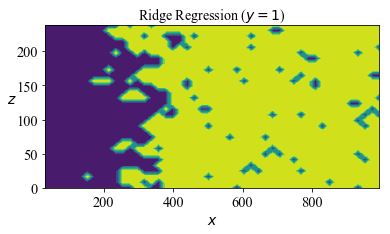

In [12]:
plt.figure(figsize=(6,3));
plt.contourf(x,z,y_pred[2,:,:])
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$z$',rotation=0, fontsize=14)
plt.title("Ridge Regression ($y=1$)", fontsize=14)
plt.ylim(z[0],z[niz-1])
plt.savefig('ridge.png',dpi=300)

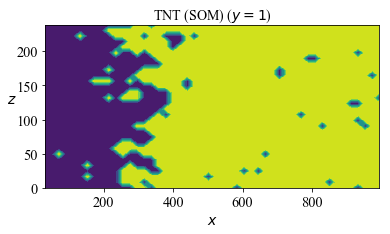

In [13]:
plt.figure(figsize=(6,3));
plt.contourf(x,z,y_t1000[2,:,:])
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$z$',rotation=0, fontsize=14)
plt.title("TNT (SOM) ($y=1$)", fontsize=14)
plt.ylim(z[0],z[niz-1])
plt.savefig('SOM.png',dpi=300)

### Report Mean Squared Error

In [14]:
#Mean squared error for Ridge Regression
metrics.mean_squared_error(y_pred.flatten(),y_t1000.flatten())

0.03009259259259259